In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [47]:
def compute_rolling_percentiles(returns_data, window=24):
    """
    Compute rolling percentiles of ETF returns relative to their past values.

    Parameters:
    - returns_data: A pandas DataFrame with ETF return data, indexed by date.
    - window: The number of past observations to include in the rolling window.

    Returns:
    - percentiles: A pandas DataFrame of the same shape as returns_data containing the rolling percentiles.
    """
    # Function to compute the percentile of the last value in the window
    def percentile_of_last(x):
        if len(x) < window:
            # If there are fewer than 'window' elements, return NaN
            return np.nan
        else:
            # Compute the percentile of the last value relative to the others
            return (np.sum(x[-1] > x[:-1]) / len(x[:-1])) * 100

    # Apply the percentile_of_last function over a rolling window for each ETF
    percentiles = returns_data.rolling(window=window + 1).apply(percentile_of_last, raw=True)

    return percentiles

In [26]:
etfs_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "inputs", "wrds_etf_returns.csv"))

etfs_data["date"] = pd.to_datetime(etfs_data["date"])
etfs_data.set_index("date", inplace=True)

# # compute log returns
# returns_data = np.log(etfs_data).diff(22)
returns_data = etfs_data.copy()
returns_data = returns_data[[col for col in returns_data.columns if "t+1" not in col]]

returns_data.tail()

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,
2022-07-29,0.088091,0.059729,0.092242,0.069395,0.090783,0.126209,0.031502,0.053038,0.031924,0.169229
2022-08-31,-0.041658,-0.035434,0.026178,-0.019773,-0.028744,-0.064141,-0.018700,0.005260,-0.059436,-0.045997
2022-09-30,-0.096642,-0.097277,-0.099631,-0.079228,-0.109818,-0.127263,-0.084433,-0.118822,-0.025525,-0.085404
2022-10-31,0.078142,0.085491,0.222866,0.112646,0.130101,0.073741,0.086236,0.019200,0.091768,0.011031
2022-11-30,0.054102,0.110679,0.012697,0.066321,0.075212,0.061346,0.059379,0.067315,0.046150,0.014749


In [52]:
# compute volatility
volatility = (returns_data.rolling(6).std() * np.sqrt(12) * 100)

# compute drawdown
cummulative_portfolio_returns = np.exp(returns_data.cumsum())
rolling_max = cummulative_portfolio_returns.cummax()

rolling_max.loc[0, :] = 1.0

drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

drawdown = drawdown.dropna()
drawdown.index = pd.to_datetime(drawdown.index)

# compute rolling percentiles of volatility and drawdown
volatility_percentiles = compute_rolling_percentiles(volatility, window=24)
drawdown_percentiles = compute_rolling_percentiles(drawdown, window=24)

# smooth percentiles
volatility_percentiles_smooth = volatility_percentiles.rolling(3).mean()
drawdown_percentiles_smooth = drawdown_percentiles.rolling(3).mean()

/Users/danieloliveira/opt/anaconda3/envs/cml-fin/lib/python3.7/site-packages/pandas/core/indexes/base.py:4024: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)


<AxesSubplot:xlabel='date'>

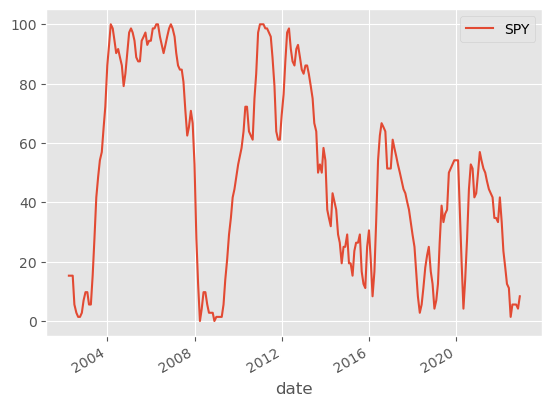

In [55]:
drawdown_percentiles_smooth[["SPY"]].plot()